In [1]:
%matplotlib nbagg
import jungfrau_utils as ju
import numpy as np
import json
import h5py
import matplotlib.pyplot as plt
import scipy
from scipy.ndimage.filters import gaussian_filter
from scipy.special import erf
from scipy.optimize import curve_fit
import os
import time

/sf/alvra/anaconda/4.4.0/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
#Following lines are to define a couple of functions that will be used later.

def rebin_sum(a):
    if a.size%bin_ != 0:
        a = a[0:a.size//bin_ * bin_]

    return a.reshape((-1, bin_)).sum(axis=1)

def rebin_mean(a):
    if a.size%bin_ != 0:
        a = a[0:a.size//bin_ * bin_]

    return a.reshape((-1, bin_)).mean(axis=1)

# Convert energy to a number of photons counting values falling within a particular range.
# This will always return integer photon counts.
def convert_to_photon_num_range(image):
    return np.ceil(np.divide(image - photon_range[0], np.mean(photon_range)))

# Convert energy to a number of photons using the central energy of a single photon.
# This can return fractional number of photons.`
def convert_to_photon_num_mean(image):
    return image / np.mean(photon_range)

In [3]:
# Take the correct pedestal file (usually located in /sf/alvra/data/*pgroup*/res/JF_pedestals)
# Take the correct gains.h5 file (usually located in /sf/alvra/config/jungfrau/gainMaps/JF02T09V01/)

#pede_file = "/sf/alvra/data/res/p16581/pedestal_20180307_2303_res.h5"
pede_file = "/sf/alvra/data/p17803/res/JF_pedestals/pedestal_20190131_1436.JF02T09V01.res.h5"
#pede_file = "/sf/alvra/data/p17803/res/JF_pedestals/pedestal_20190124_2035.JF02T09V01.res.h5"
gain_file = "/sf/alvra/config/jungfrau/gainMaps/JF02T09V01/gains.h5"

with h5py.File(gain_file, "r") as file: 
    G = file["gains"][:]
    
with h5py.File(pede_file, "r") as file: 
    P = file["gains"][:]
    mask = file["pixel_mask"][:]
    
print("Dimensions of G: ", G.shape)

channel_JFimages = "data/JF02T09V01/data"
channel_pulse_idsJF = "data/JF02T09V01/pulse_id"

channel_delay = "data/SLAAR11-LMOT-M451:ENC_1_BS/data"              #Delay of pump-probe delay stage
channel_energy = "data/SLAAR11-LTIM01-EVR0:DUMMY_PV3_NBS/data"      #Mono energy in eV
channel_pulse_idsBS = "data/SLAAR11-LMOT-M451:ENC_1_BS/pulse_id"      #Pulse ids taken from pump-probe delay stage (100 Hz)

#channel_PIPS_trans = "data/SARES11-GES1:CH1_VAL_GET/data"           #X-ray TRANS diode to PRIME Keysight (channel 1)
#channel_PIPS_fluo = "data/SARES11-GES1:CH2_VAL_GET/data"            #X-ray FLUO diode to PRIME Keysight (channel 2)
channel_Izero = "data/SARES11-LSCP10-FNS:CH2:VAL_GET/data"          #Izero diode to PRIME Ioxos (channel 1)
#channel_Izero2 = "data/SARES11-LSCP10-FNS:CH0:VAL_GET/data"          #Izero diode to PRIME Ioxos (channel 0)
#channel_Izero3 = "data/SARES11-LSCP10-FNS:CH3:VAL_GET/data"          #Izero diode to PRIME Ioxos (channel 3)
#channel_Izero4 = "data/SARES11-LSCP10-FNS:CH2:VAL_GET/data"         #Izero diode to PRIME Ioxos (channel 2)
#channel_LaserDiode = "data/SLAAR11-LSCP1-FNS:CH0:VAL_GET/data"      #Laser diode to ESA Laser Ioxos 
#channel_Laser_refDiode = "data/SLAAR11-LSCP1-FNS:CH2:VAL_GET/data"  #Laser diode leaking from beampath, to ESA Laser Ioxos 
#channel_LAM_delaystage = "data/SLAAR11-LTIM01-EVR0:DUMMY_PV2_NBS/data"       #LAM internal stage position in mm
#channel_LAM_stepper = "data/SLAAR11-LTIM01-EVR0:DUMMY_PV10_NBS/data"         #LAM stepper motor (used for feedback)
#channel_PALM_eTOF = "data/SAROP11-PALMK118:CH2_BUFFER/data"                 #PALM eTof from Ch2
#channel_PALM_drift = "data/SAROP11-PALMK118:CH2_VAL_GET/data"               #PALM drift

Dimensions of G:  (4, 512, 9216)


In [4]:
def LoadData_JF(filename):
    with h5py.File(filename, 'r') as JF_file:
        pulse_ids = JF_file[channel_pulse_idsJF][:]
        pulse_ids = np.reshape(pulse_ids, (pulse_ids.size,))
        
        #reprate_FEL = ((pulse_ids%10 == 0) & (pulse_ids%20 != 0))              #This is for 10 Hz
        #reprate_laser = pulse_ids%20 == 0                                      #This is for 5 Hz
        reprate_FEL = ((pulse_ids%4 == 0) & (pulse_ids%8 != 0))                #This is for 25 Hz
        reprate_laser = pulse_ids%8 == 0                                       #This is for 12.5 Hz
        
        image_JF_ON = JF_file[channel_JFimages][:,:,:][reprate_laser]
        image_JF_OFF = JF_file[channel_JFimages][:,:,:][reprate_FEL]
        
        image_roi1_ON = image_JF_ON[:, roi1[0][0]:roi1[0][1], roi1[1][0]:roi1[1][1]]
        image_roi2_ON = image_JF_ON[:, roi2[0][0]:roi2[0][1], roi2[1][0]:roi2[1][1]]
        
        image_roi1_OFF = image_JF_OFF[:, roi1[0][0]:roi1[0][1], roi1[1][0]:roi1[1][1]]
        image_roi2_OFF = image_JF_OFF[:, roi2[0][0]:roi2[0][1], roi2[1][0]:roi2[1][1]]
        
    return image_roi1_ON, image_roi1_OFF, image_roi2_ON, image_roi2_OFF

def LoadData_BS(filename):
    with h5py.File(filename, 'r') as BS_file:
        pulse_ids = BS_file[channel_pulse_idsBS][:]
        pulse_ids = np.reshape(pulse_ids, (pulse_ids.size,))
        
        #reprate_FEL = ((pulse_ids%10 == 0) & (pulse_ids%20 != 0))              #This is for 10 Hz
        #reprate_laser = pulse_ids%20 == 0                                      #This is for 5 Hz
        reprate_FEL = ((pulse_ids%4 == 0) & (pulse_ids%8 != 0))                #This is for 25 Hz
        reprate_laser = pulse_ids%8 == 0                                       #This is for 12.5 Hz
        
        Izero_pump = BS_file[channel_Izero][:][reprate_laser]
        Izero_unpump = BS_file[channel_Izero][:][reprate_FEL]      
        
        delay = BS_file[channel_delay][:][reprate_FEL]
        energy = BS_file[channel_energy][:][reprate_FEL]
        
    return delay, energy, Izero_pump, Izero_unpump

def errfunc(x, a, b, c, d):
    return a + b*erf((c-x)*np.sqrt(np.log(2))/(np.abs(d)))

In [5]:
fn = "/das/work/p17/p17803/alvra_beamline_scripts/FeBpy_500fs_007_crop/CytC_Fe3_XES_timescan_7p5uJ_350nm_8000eV_014_crop_12.h5"
jf_file = h5py.File(fn)
imageROI1 = jf_file["JF02T09V01_crop/roi1"]
h5py.File.close

KeyError: 'Unable to open object (component not found)'

In [6]:
imageROI1.shape

(2000, 100, 200)

<IPython.core.display.Javascript object>


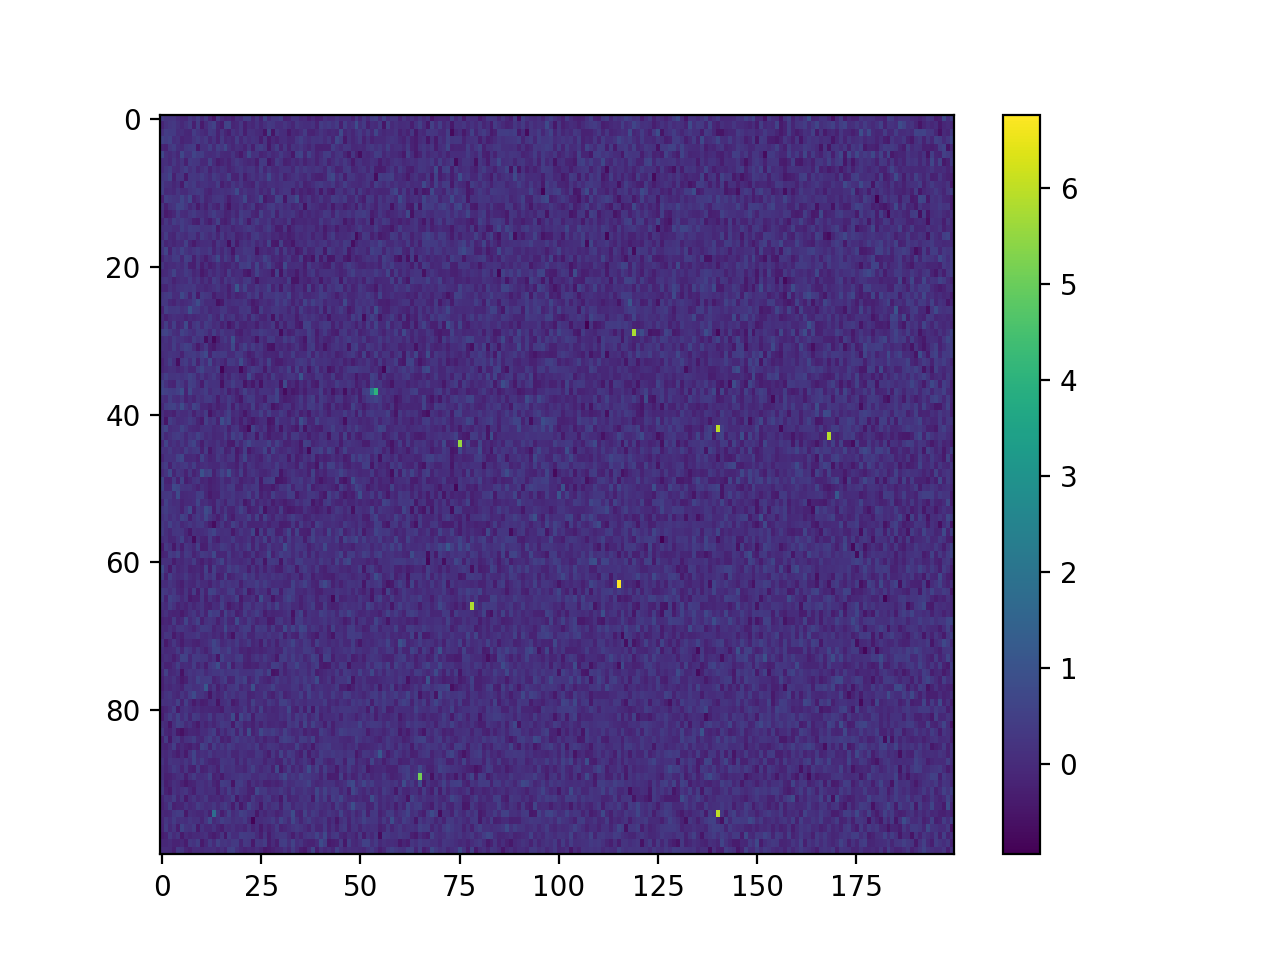

In [7]:
plt.figure()
plt.imshow(imageROI1[0], aspect='auto')
plt.colorbar()
plt.show()

In [ ]:
plt.figure()
plt.hist(imageROI1[1].ravel(),250,[0,10])
plt.ylim((0,10))
plt.show()

In [8]:
threshold_low = 3
threshold_high = 8

imageROI_= ju.apply_gain_pede(image_ON_2D_roi1, G=G_r_roi1, P=P_r_roi1, pixel_mask=mask_r_roi1, highgain=False)


NameError: name 'image_ON_2D_roi1' is not defined

In [6]:
DIR = "/sf/alvra/data/p17803/raw/scan_data/CytC_Fe3_XES_timescan_7p5uJ_350nm_8000eV_014/"
#DIR = "/sf/alvra/data/p17803/raw/"

DIR_json = "/sf/alvra/data/p17803/res/scan_info/"

!ls -lah -t /sf/alvra/data/p17803/raw/scan_data/CytC_Fe3_XES_timescan_7p5uJ_350nm_8000eV_014/
#!ls -lah -t /sf/alvra/data/p17803/raw/


!hostname

listfile = os.listdir(DIR)
number_files = len(listfile)
print ("There are",number_files,"files in the folder", DIR)

total 3.8T
drwxrwsr-x. 159 root p17803  32K Jan 31 22:55 ..
drwxrwsr-x.   2 root p17803  32K Jan 26 22:05 .
-rw-r--r--.   1 root p17803 3.3G Jan 26 22:05 CytC_Fe3_XES_timescan_7p5uJ_350nm_8000eV_014_step0051.BSREAD.h5
-rw-r--r--.   1 root p17803  33M Jan 26 22:02 CytC_Fe3_XES_timescan_7p5uJ_350nm_8000eV_014_step0051.BSREAD_CA.h5
-rw-r--r--.   1 root p17803  71G Jan 26 22:02 CytC_Fe3_XES_timescan_7p5uJ_350nm_8000eV_014_step0051.JF02T09V01.h5
-rw-r--r--.   1 root p17803 3.3G Jan 26 21:59 CytC_Fe3_XES_timescan_7p5uJ_350nm_8000eV_014_step0050.BSREAD.h5
-rw-r--r--.   1 root p17803  34M Jan 26 21:57 CytC_Fe3_XES_timescan_7p5uJ_350nm_8000eV_014_step0050.BSREAD_CA.h5
-rw-r--r--.   1 root p17803  71G Jan 26 21:56 CytC_Fe3_XES_timescan_7p5uJ_350nm_8000eV_014_step0050.JF02T09V01.h5
-rw-r--r--.   1 root p17803 3.3G Jan 26 21:54 CytC_Fe3_XES_timescan_7p5uJ_350nm_8000eV_014_step0049.BSREAD.h5
-rw-r--r--.   1 root p17803  34M Jan 26 21:51 CytC_Fe3_XES_timescan_7p5uJ_350nm_8000eV_014_step0049.BSREAD_C

ra-c-040.psi.ch
There are 156 files in the folder /sf/alvra/data/p17803/raw/scan_data/CytC_Fe3_XES_timescan_7p5uJ_350nm_8000eV_014/


<HDF5 file "CytC_Fe3_XES_timescan_7p5uJ_350nm_8000eV_014_step0012.JF02T09V01.h5" (mode r)>
(8000, 512, 9216)


<IPython.core.display.Javascript object>


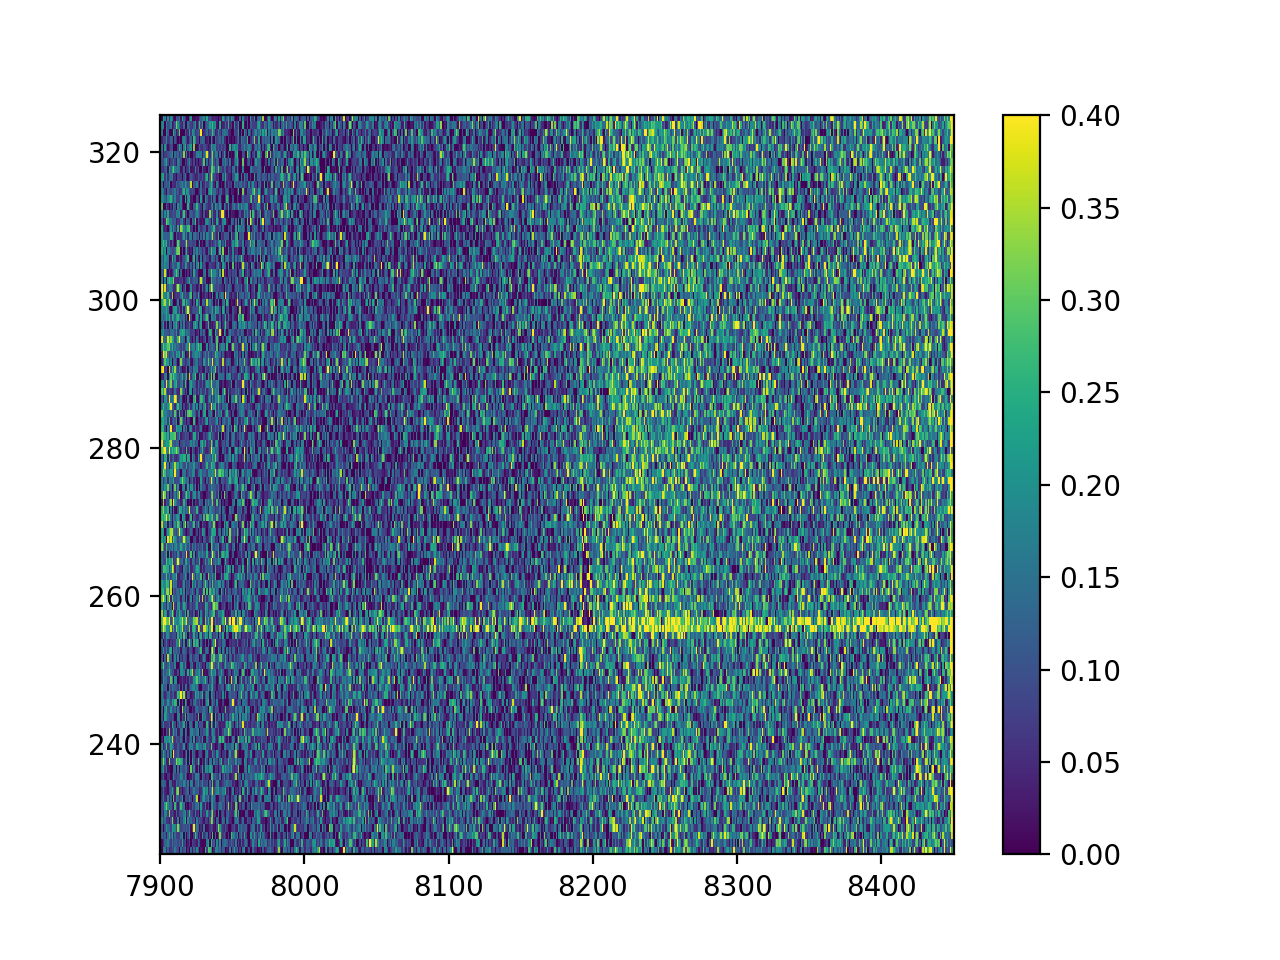

In [8]:
# First we load the first images of a file to check if everything is fine with the pedestal & gain files (check highgain True or False)
# We can see also how the ROIs look like (will be useful later)

fileName = "CytC_Fe3_XES_timescan_7p5uJ_350nm_8000eV_014_step0012.JF02T09V01.h5"
#fileName = "CytC_Fe3_timescan_5uJ_288nm_7122eV_003_step0015.JF02T09V01.h5"

jf_file = h5py.File(DIR + fileName)

print(jf_file)

images = jf_file[channel_JFimages]
pulse_ids = jf_file[channel_pulse_idsJF]
print (images.shape)

nframes = 100

#nframes=images.shape(0)

total = 0
threshold_low = 3
threshold_high = 7

#roi = [[225, 325], [6950, 7075]]
roi = [[225, 325], [7900, 8450]]
#roi = [[0, images.shape[1]], [0, images.shape[2]]]

for i in range(nframes):
    image = images[i][:]
    total += ju.apply_gain_pede(image, G=G, P=P, pixel_mask=mask, highgain=False)[roi[0][0]:roi[0][1], roi[1][0]:roi[1][1]]

total /= nframes


plt.figure()
plt.imshow(total, origin="lower", extent = [roi[1][0],roi[1][-1],roi[0][0],roi[0][-1]], aspect='auto', vmin=0, vmax=0.4)
plt.colorbar()
plt.show()

<IPython.core.display.Javascript object>


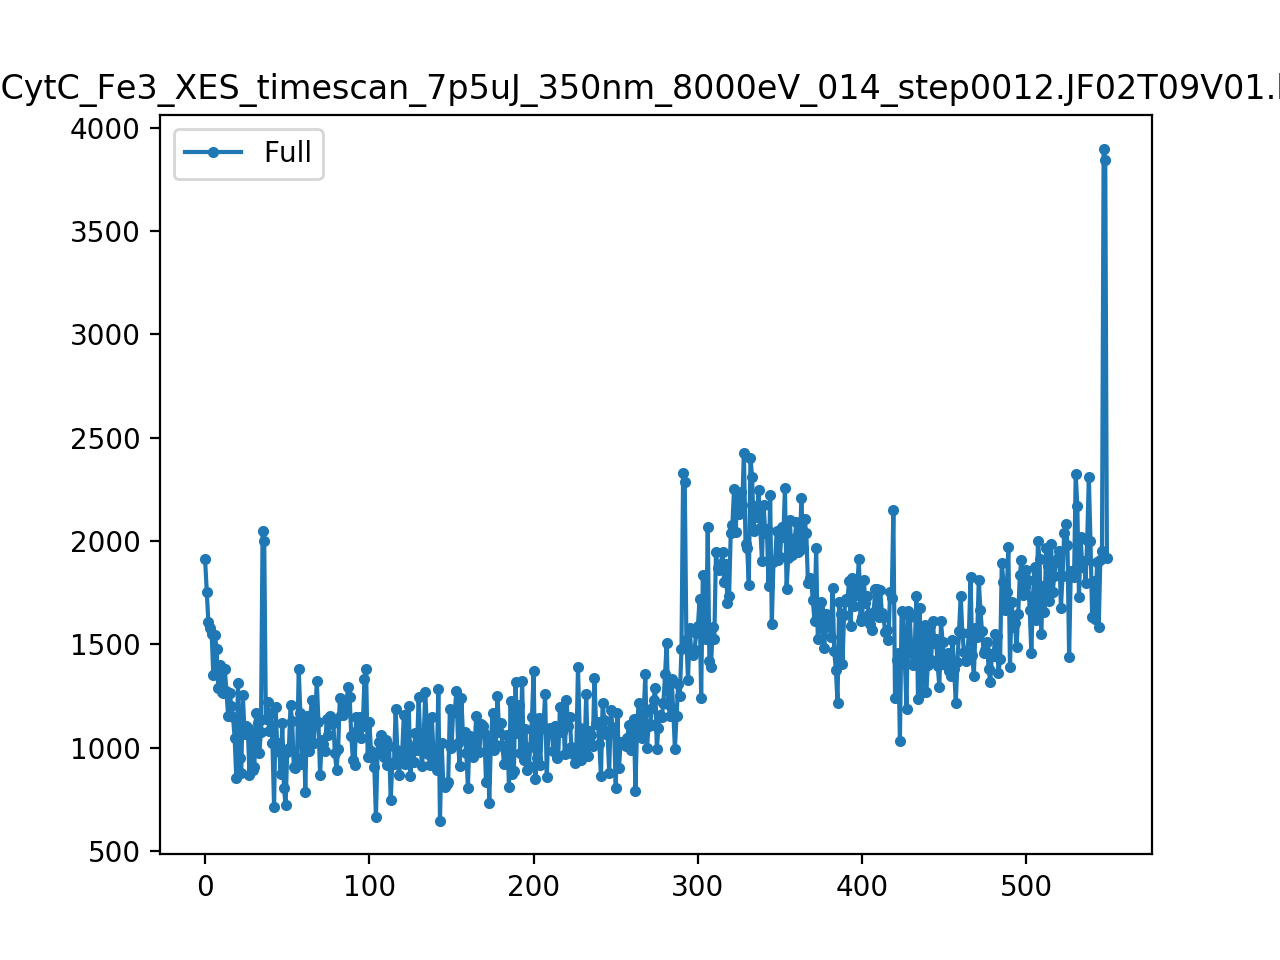

Text(0.5,1,'<HDF5 file "CytC_Fe3_XES_timescan_7p5uJ_350nm_8000eV_014_step0012.JF02T09V01.h5" (mode r)>')

In [9]:
totalImage = total * nframes
background = totalImage.sum(axis = 0)
plt.figure()

plt.plot(background, label="Full", marker='.')
#plt.ylim((-100000,100000))
plt.legend(loc="best")
plt.title(jf_file)


# Set the ROIs (roi1 & roi2 in pixels) in the next cell

In [10]:
# Ka emission 
roi1 = [[200, 300], [6900, 7100]] # change these numbers, here they are for both crystals1 (up & down) overlapped
#roi1 = [[7030, 7130], [220, 290]]
# Kb emission 
roi2 = [[200, 300], [8300, 8450]] # change these numbers, here they are for both crystals2 (up & down) overlapped

##################################################################

P_r_roi2 = P[:, roi2[0][0]:roi2[0][1], roi2[1][0]:roi2[1][1]]
G_r_roi2 = G[:, roi2[0][0]:roi2[0][1], roi2[1][0]:roi2[1][1]]
mask_r_roi2 = mask[roi2[0][0]:roi2[0][1], roi2[1][0]:roi2[1][1]]

P_r_roi1 = P[:, roi1[0][0]:roi1[0][1], roi1[1][0]:roi1[1][1]]
G_r_roi1 = G[:, roi1[0][0]:roi1[0][1], roi1[1][0]:roi1[1][1]]
mask_r_roi1 = mask[roi1[0][0]:roi1[0][1], roi1[1][0]:roi1[1][1]]

# The next cell is to analyse a single file within a scan

In [11]:
#files = ["Kalpha_Fe_foil_8keV_0.1trans_3"]          # you need to change only this name
#files = ["CytC_Fe3_timescan_5uJ_288nm_7122eV_003_step0019","CytC_Fe3_timescan_5uJ_288nm_7122eV_003_step0020","CytC_Fe3_timescan_5uJ_288nm_7122eV_003_step0022","CytC_Fe3_timescan_5uJ_288nm_7122eV_003_step0023"]

scan_name = "CytC_Fe3_XES_timescan_7p5uJ_350nm_8000eV_014"
file_name = "CytC_Fe3_XES_timescan_7p5uJ_350nm_8000eV_014_step0012"
step_number = 28

######################################################################################
start_time = time.time()
spectrum_ON_roi1 = 0
spectrum_OFF_roi1 = 0
spectrum_ON_roi2 = 0
spectrum_OFF_roi2 = 0
image_ON_all = 0
image_OFF_all = 0

json_file = DIR_json + scan_name + "_scan_info.json"
print (json_file)

with open(json_file) as file:
    data = json.load(file)
numFiles = len(data['scan_files'])
numFiles = 1
print ("Processing",numFiles,"files")

JF_single_file = DIR + file_name + ".JF02T09V01.h5"
BS_single_file = DIR + file_name + ".BSREAD.h5"

print("Processing file %s" % (JF_single_file))

(image_roi1_ON,image_roi1_OFF,image_roi2_ON,image_roi2_OFF) = LoadData_JF(str(data['scan_files'][step_number][1]))
(Delay_mm,Energy_eV,Izero_pump,Izero_unpump) = LoadData_BS(str(data['scan_files'][step_number][0]))

meanI0pump = np.median(Izero_pump)
sigmaI0pump = np.std(Izero_pump)
meanI0unpump = np.median(Izero_unpump)
sigmaI0unpump = np.std(Izero_unpump) 

nframes_ON = np.ma.size(image_roi1_ON,0)
nframes_OFF = np.ma.size(image_roi1_OFF,0)
print (nframes_ON, nframes_OFF)

#threshold = 2
threshold_low = 3
threshold_high = 7.5
sigma_low=1.1
sigma_high=5
#photon_range = (6, 7)

for j in range(nframes_ON):
        image_ON_2D_roi1 = image_roi1_ON[j,:,:]
        image_ON_2D_roi1= ju.apply_gain_pede(image_ON_2D_roi1, G=G_r_roi1, P=P_r_roi1, pixel_mask=mask_r_roi1, highgain=False)
        image_raw = image_ON_2D_roi1
        image_ON_2D_roi1[image_ON_2D_roi1 < threshold_low] = 0
        image_ON_2D_roi1[image_ON_2D_roi1 > threshold_high] = 0
#         image_ON_2D_roi1 = convert_to_photon_num_range(image_ON_2D_roi1)
        if Izero_pump[j]>(meanI0pump-sigma_low*sigmaI0pump) and Izero_pump[j]<(meanI0pump+sigma_high*sigmaI0pump):
            spectrum_ON_roi1 += image_ON_2D_roi1.sum(axis=0)/Izero_pump[j]
            image_ON_all += image_ON_2D_roi1
            
        image_OFF_2D_roi1 = image_roi1_OFF[j,:,:]
        image_OFF_2D_roi1= ju.apply_gain_pede(image_OFF_2D_roi1, G=G_r_roi1, P=P_r_roi1, pixel_mask=mask_r_roi1, highgain=False)
        image_OFF_2D_roi1[image_OFF_2D_roi1 < threshold_low] = 0
        image_OFF_2D_roi1[image_OFF_2D_roi1 > threshold_high] = 0
#         image_OFF_2D_roi1 = convert_to_photon_num_range(image_OFF_2D_roi1)
        if Izero_unpump[j]>(meanI0unpump-sigma_low*sigmaI0unpump) and Izero_unpump[j]<(meanI0unpump+sigma_high*sigmaI0unpump):
            spectrum_OFF_roi1 += image_OFF_2D_roi1.sum(axis=0)/Izero_unpump[j]
            image_OFF_all += image_OFF_2D_roi1
        
        image_ON_2D_roi2 = image_roi2_ON[j,:,:]
        image_ON_2D_roi2= ju.apply_gain_pede(image_ON_2D_roi2, G=G_r_roi2, P=P_r_roi2, pixel_mask=mask_r_roi2, highgain=False)
        image_ON_2D_roi2[image_ON_2D_roi2 < threshold_low] = 0
        image_ON_2D_roi2[image_ON_2D_roi2 > threshold_high] = 0
#         image_ON_2D_roi2 = convert_to_photon_num_range(image_ON_2D_roi2)
        if Izero_pump[j]>(meanI0pump-sigma_low*sigmaI0pump) and Izero_pump[j]<(meanI0pump+sigma_high*sigmaI0pump):
            spectrum_ON_roi2 += image_ON_2D_roi2.sum(axis=0)/Izero_pump[j]
        
        image_OFF_2D_roi2 = image_roi2_OFF[j,:,:]
        image_OFF_2D_roi2= ju.apply_gain_pede(image_OFF_2D_roi2, G=G_r_roi2, P=P_r_roi2, pixel_mask=mask_r_roi2, highgain=False)
        image_OFF_2D_roi2[image_OFF_2D_roi2 < threshold_low] = 0
        image_OFF_2D_roi2[image_OFF_2D_roi2 > threshold_high] = 0
#         image_OFF_2D_roi2 = convert_to_photon_num_range(image_OFF_2D_roi2)
        if Izero_unpump[j]>(meanI0unpump-sigma_low*sigmaI0unpump) and Izero_unpump[j]<(meanI0unpump+sigma_high*sigmaI0unpump):
            spectrum_OFF_roi2 += image_OFF_2D_roi2.sum(axis=0)/Izero_unpump[j]
    
print ("Job done! It took",round((time.time() - start_time),2),"seconds to process the file")


/sf/alvra/data/p17803/res/scan_info/CytC_Fe3_XES_timescan_7p5uJ_350nm_8000eV_014_scan_info.json
Processing 1 files
Processing file /sf/alvra/data/p17803/raw/scan_data/CytC_Fe3_XES_timescan_7p5uJ_350nm_8000eV_014/CytC_Fe3_XES_timescan_7p5uJ_350nm_8000eV_014_step0012.JF02T09V01.h5
4000 4000
Job done! It took 218.09 seconds to process the file


<IPython.core.display.Javascript object>


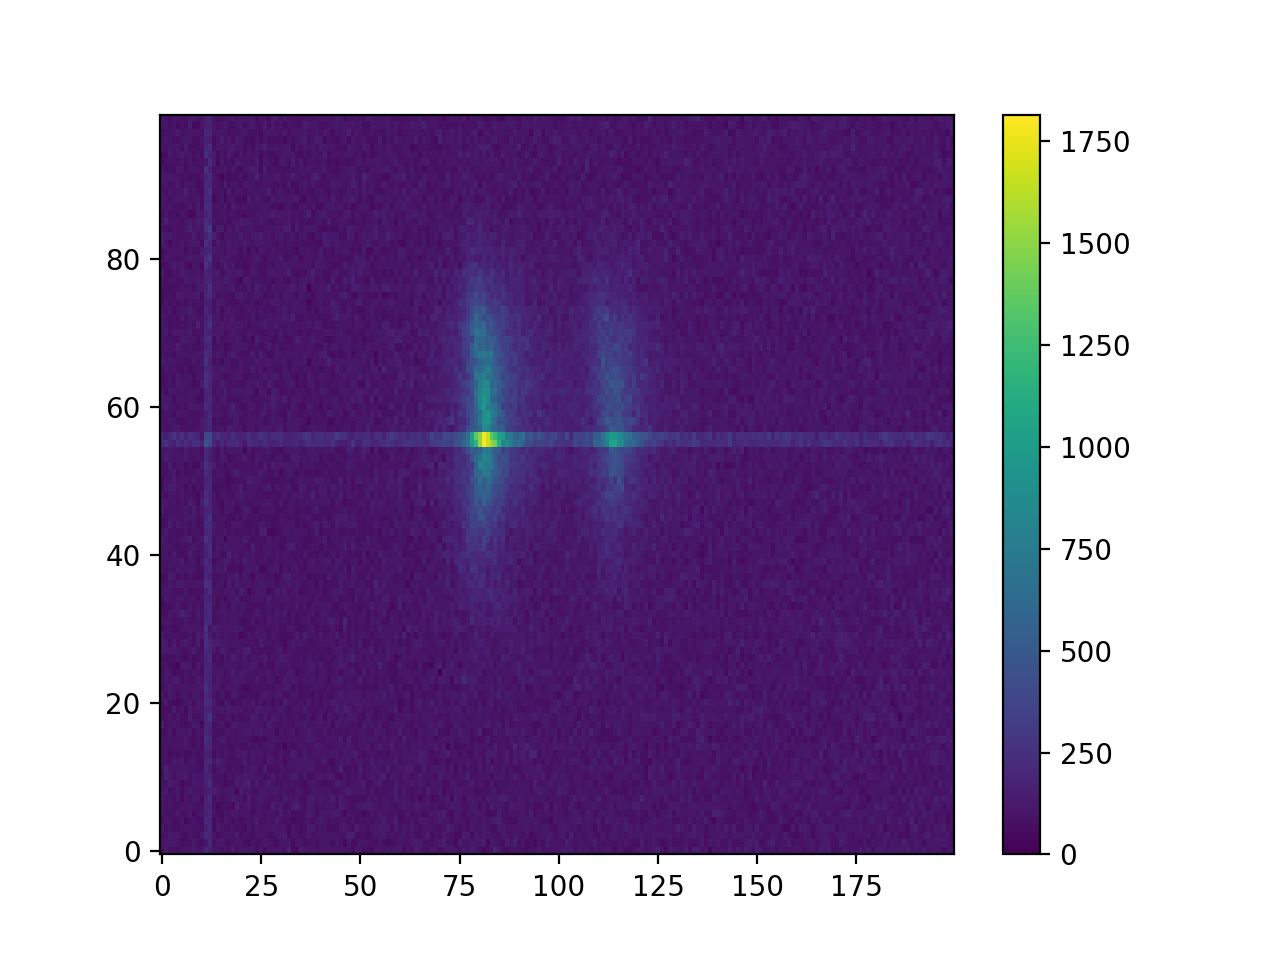

In [12]:
plt.figure()
plt.imshow(image_ON_all, origin="lower", aspect='auto')#, vmin=0, vmax=0.4)
plt.colorbar()
plt.show()

# The next cell is to analyse a single file or a series of identical ones to be summed up

In [14]:
#files = ["Kalpha_Fe_foil_8keV_0.1trans_3"]          # you need to change only this name
#files = ["CytC_Fe3_timescan_5uJ_288nm_7122eV_003_step0019","CytC_Fe3_timescan_5uJ_288nm_7122eV_003_step0020","CytC_Fe3_timescan_5uJ_288nm_7122eV_003_step0022","CytC_Fe3_timescan_5uJ_288nm_7122eV_003_step0023"]

files = ["CytC_Fe3_XES_timescan_7p5uJ_350nm_8000eV_014_step0012"]
######################################################################################
start_time = time.time()
spectrum_ON_roi1 = 0
spectrum_OFF_roi1 = 0
spectrum_ON_roi2 = 0
spectrum_OFF_roi2 = 0
        
for f in files:
    
    JF_single_file = DIR + f + ".JF02T09V01.h5"
    BS_single_file = DIR + f + ".BSREAD.h5"
    print("Processing file %s" % (JF_single_file))
    
    (image_roi1_ON,image_roi1_OFF,image_roi2_ON,image_roi2_OFF,pulse_ids,pulse_ids2) = LoadData_JF(str(JF_single_file))
    (Delay_mm,Energy_eV,Izero_pump,Izero_unpump) = LoadData_BS(str(BS_single_file))
    
    meanI0pump = np.median(Izero_pump)
    sigmaI0pump = np.std(Izero_pump)
    meanI0unpump = np.median(Izero_unpump)
    sigmaI0unpump = np.std(Izero_unpump) 
    
    nframes_ON = np.ma.size(image_roi1_ON,0)
    nframes_OFF = np.ma.size(image_roi1_OFF,0)
    print (nframes_ON, nframes_OFF)
    
    #threshold = 2
    threshold_low = 3 
    threshold_high = 8
    #photon_range = (6, 7)
    
    for j in range(nframes_ON):
        image_ON_2D_roi1 = image_roi1_ON[j,:,:]
        image_ON_2D_roi1= ju.apply_gain_pede(image_ON_2D_roi1, G=G_r_roi1, P=P_r_roi1, pixel_mask=mask_r_roi1, highgain=False)
        image_ON_2D_roi1[image_ON_2D_roi1 < threshold_low] = 0
        image_ON_2D_roi1[image_ON_2D_roi1 > threshold_high] = 0
#         image_ON_2D_roi1 = convert_to_photon_num_range(image_ON_2D_roi1)
        if Izero_pump[j]>(meanI0pump-1.2*sigmaI0pump) and Izero_pump[j]<(meanI0pump+1.2*sigmaI0pump):
            spectrum_ON_roi1 += image_ON_2D_roi1.sum(axis=0)/Izero_pump[j]
        
        image_OFF_2D_roi1 = image_roi1_OFF[j,:,:]
        image_OFF_2D_roi1= ju.apply_gain_pede(image_OFF_2D_roi1, G=G_r_roi1, P=P_r_roi1, pixel_mask=mask_r_roi1, highgain=False)
        image_OFF_2D_roi1[image_OFF_2D_roi1 < threshold_low] = 0
        image_OFF_2D_roi1[image_OFF_2D_roi1 > threshold_high] = 0
#         image_OFF_2D_roi1 = convert_to_photon_num_range(image_OFF_2D_roi1)
        if Izero_unpump[j]>(meanI0unpump-1.2*sigmaI0unpump) and Izero_unpump[j]<(meanI0unpump+1.2*sigmaI0unpump):
            spectrum_OFF_roi1 += image_OFF_2D_roi1.sum(axis=0)/Izero_unpump[j]
        
        image_ON_2D_roi2 = image_roi2_ON[j,:,:]
        image_ON_2D_roi2= ju.apply_gain_pede(image_ON_2D_roi2, G=G_r_roi2, P=P_r_roi2, pixel_mask=mask_r_roi2, highgain=False)
        image_ON_2D_roi2[image_ON_2D_roi2 < threshold_low] = 0
        image_ON_2D_roi2[image_ON_2D_roi2 > threshold_high] = 0
#         image_ON_2D_roi2 = convert_to_photon_num_range(image_ON_2D_roi2)
        if Izero_pump[j]>(meanI0pump-1.2*sigmaI0pump) and Izero_pump[j]<(meanI0pump+1.2*sigmaI0pump):
            spectrum_ON_roi2 += image_ON_2D_roi2.sum(axis=0)/Izero_pump[j]
        
        image_OFF_2D_roi2 = image_roi2_OFF[j,:,:]
        image_OFF_2D_roi2= ju.apply_gain_pede(image_OFF_2D_roi2, G=G_r_roi2, P=P_r_roi2, pixel_mask=mask_r_roi2, highgain=False)
        image_OFF_2D_roi2[image_OFF_2D_roi2 < threshold_low] = 0
        image_OFF_2D_roi2[image_OFF_2D_roi2 > threshold_high] = 0
#         image_OFF_2D_roi2 = convert_to_photon_num_range(image_OFF_2D_roi2)
        if Izero_unpump[j]>(meanI0unpump-1.2*sigmaI0unpump) and Izero_unpump[j]<(meanI0unpump+1.2*sigmaI0unpump):
            spectrum_OFF_roi2 += image_OFF_2D_roi2.sum(axis=0)/Izero_unpump[j]
        
print ("Job done! It took",round((time.time() - start_time),2),"seconds to process",np.size(files),"file(s)")


Processing file /sf/alvra/data/p17803/raw/scan_data/CytC_Fe3_XES_timescan_7p5uJ_350nm_8000eV_014/CytC_Fe3_XES_timescan_7p5uJ_350nm_8000eV_014_step0012.JF02T09V01.h5


ValueError: not enough values to unpack (expected 6, got 4)

In [ ]:
# Let's check if everything worked out fine, plotting one spectrum for instance the spectra with laser OFF.
# This is for ROI1

x_axis = np.arange(roi1[1][0], roi1[1][1])
plt.figure()

plt.subplot(211)
plt.plot(x_axis,spectrum_OFF_roi1, label="ROI1, Spectra OFF", marker='.')
plt.legend(loc="best")
plt.title(jf_file)
x_axis = np.arange(roi2[1][0], roi2[1][1])
plt.subplot(212)
plt.plot(x_axis,spectrum_OFF_roi2,label="ROI2, Spectra OFF",marker='.')
plt.legend(loc="best")

In [ ]:
# # # This is for plotting laser on-off spectra from Roi1 to look for pump-probe

bin_ = 1   # change the bin size if wanted, 1 is every pixel

spectra_on = spectrum_ON_roi1.copy()
spectra_off = spectrum_OFF_roi1.copy()

x_axis = np.arange(roi1[1][0], roi1[1][1])

spectra_on_rebin1 = rebin_sum(spectra_on)
spectra_off_rebin1 = rebin_sum(spectra_off)
x_axis_rebin1 = rebin_mean(x_axis)

spectra_on_err1=np.sqrt(spectra_on_rebin1)
spectra_off_err1=np.sqrt(spectra_off_rebin1)

plt.figure()
plt.subplot(211)
plt.plot(x_axis_rebin1,spectra_on_rebin1, label="ON",marker='.')
plt.plot(x_axis_rebin1,spectra_off_rebin1, label="OFF",marker='.')
plt.legend(loc="best")
plt.title(jf_file)

low_err= (spectra_on_rebin1 - spectra_off_rebin1)-np.sqrt(spectra_on_err1**2+spectra_off_err1**2)
high_err= (spectra_on_rebin1 - spectra_off_rebin1)+np.sqrt(spectra_on_err1**2+spectra_off_err1**2)
#x_axis_rebin1,
plt.subplot(212)
plt.plot(spectra_on_rebin1 - spectra_off_rebin1, label="ON - OFF",marker='.')
plt.legend(loc="best")
#plt.fill_between(x_axis_rebin1, low_err, high_err, color='lightblue')
plt.show()

In [ ]:
# # # This is for plotting laser on-off spectra from Roi2 to look for pump-probe

bin_ = 2     # change the bin size if wanted, 1 is every pixel

spectra_on = spectrum_ON_roi2.copy()
spectra_off = spectrum_OFF_roi2.copy()

x_axis = np.arange(roi2[1][0], roi2[1][1])

spectra_on_rebin2 = rebin_sum(spectra_on)
spectra_off_rebin2 = rebin_sum(spectra_off)
x_axis_rebin2 = rebin_mean(x_axis)

spectra_on_err2=np.sqrt(spectra_on_rebin2)
spectra_off_err2=np.sqrt(spectra_off_rebin2)
plt.figure()
plt.subplot(211)
plt.plot(x_axis_rebin2,spectra_on_rebin2, label="ON",marker='.')
plt.plot(x_axis_rebin2,spectra_off_rebin2, label="OFF",marker='.')
plt.legend(loc="best")
plt.title(jf_file)

low_err= (spectra_on_rebin2 - spectra_off_rebin2)-np.sqrt(spectra_on_err2**2+spectra_off_err2**2)
high_err= (spectra_on_rebin2 - spectra_off_rebin2)+np.sqrt(spectra_on_err2**2+spectra_off_err2**2)

plt.subplot(212)
plt.plot(x_axis_rebin2,spectra_on_rebin2 - spectra_off_rebin2, label="ON - OFF",marker='.')
plt.legend(loc="best")
plt.fill_between(x_axis_rebin2, low_err, high_err, color='lightblue')
plt.show()

# The next cell is for looping over several files of a scan.

In [ ]:
scan_name ="FeBpy_monoscan_350nm_10uJ_500fs_007"          # you need to change only this name

######################################################################################
start_time = time.time()
intermediate_time = time.time()
json_file = DIR_json + scan_name + "_scan_info.json"
print (json_file)

with open(json_file) as file:
    data = json.load(file)
numFiles = len(data['scan_files'])
#numFiles = 1
looptime0 = time.time()
print ("Processing",numFiles,"files")

threshold = 2
threshold_low = 3 
threshold_high = 8
#photon_range = (6, 7)

Energy_eV = []
Delay_mm = []
XAS_trans_roi1 = []
Error_XAS_roi1 = []
XAS_trans_roi2 = []
Error_XAS_roi2 = []
RIXS_transient_roi1 = []
RIXS_transient_roi2 = []
Error_transient_roi1 = []
Error_transient_roi2 = []
RIXS_unpumped_roi1 = []
RIXS_unpumped_roi2 = []
Error_unpumped_roi1 = []
Error_unpumped_roi2 = []
RIXS_pumped_roi1 = []
RIXS_pumped_roi2 = []
Error_pumped_roi1 = []
Error_pumped_roi2 = []

for i in range(0,numFiles):
    print("step",i+1,"of",numFiles,": Processing %s" % (str(data['scan_files'][i][1])))
    
    spectrum_ON_roi1 = 0
    spectrum_OFF_roi1 = 0
    spectrum_ON_roi2 = 0
    spectrum_OFF_roi2 = 0

    (delay_loop, energy_loop, Izero_pump, Izero_unpump) = LoadData_BS(str(data['scan_files'][i][0]))    
    looptime1 = time.time() - looptime0
    print("t1 = " + str(looptime1) + "  time after load data BS ")
    
    energy_loop = [x for x in energy_loop if (x > 0)]     #This is to prevent that some occasional zeros screw up the mean value calculated below
    delay_loop = [x for x in delay_loop if (x > 0)]       #This is to prevent that some occasional zeros screw up the mean value calculated below
    Delay_mm.append(np.mean(delay_loop))
    Energy_eV.append(np.mean(energy_loop))
    
    meanI0pump = np.median(Izero_pump)
    sigmaI0pump = np.std(Izero_pump)
    meanI0unpump = np.median(Izero_unpump)
    sigmaI0unpump = np.std(Izero_unpump) 
    
    (image_ON_single_roi1,image_OFF_single_roi1,image_ON_single_roi2,image_OFF_single_roi2) = LoadData_JF(str(data['scan_files'][i][1]))
    looptime2 = time.time() - looptime0
    print("t2 = " + str(looptime2)+ "  time after load data JF")  
    
    nframes_ON = np.ma.size(image_ON_single_roi1,0)
    nframes_OFF = np.ma.size(image_OFF_single_roi1,0)
    print (nframes_ON, nframes_OFF)
    
    for j in range(nframes_ON):
        image_ON_2D_roi1 = image_ON_single_roi1[j,:,:]
        image_ON_2D_roi1= ju.apply_gain_pede(image_ON_2D_roi1, G=G_r_roi1, P=P_r_roi1, pixel_mask=mask_r_roi1, highgain=False) 
        image_ON_2D_roi1[image_ON_2D_roi1 < threshold_low] = 0
        image_ON_2D_roi1[image_ON_2D_roi1 > threshold_high] = 0
#         image_ON_2D_roi1 = convert_to_photon_num_range(image_ON_2D_roi1)
        if Izero_pump[j]>(meanI0pump-1.2*sigmaI0pump) and Izero_pump[j]<(meanI0pump+1.2*sigmaI0pump):
                spectrum_ON_roi1 += image_ON_2D_roi1.sum(axis=0)/Izero_pump[j]
        
        image_OFF_2D_roi1 = image_OFF_single_roi1[j,:,:]
        image_OFF_2D_roi1= ju.apply_gain_pede(image_OFF_2D_roi1, G=G_r_roi1, P=P_r_roi1, pixel_mask=mask_r_roi1, highgain=False)
        image_OFF_2D_roi1[image_OFF_2D_roi1 < threshold_low] = 0
        image_OFF_2D_roi1[image_OFF_2D_roi1 > threshold_high] = 0
#         image_OFF_2D_roi1 = convert_to_photon_num_range(image_OFF_2D_roi1)
        if Izero_unpump[j]>(meanI0unpump-1.2*sigmaI0unpump) and Izero_unpump[j]<(meanI0unpump+1.2*sigmaI0unpump):
                spectrum_OFF_roi1 += image_OFF_2D_roi1.sum(axis=0)/Izero_unpump[j]
        
        image_ON_2D_roi2 = image_ON_single_roi2[j,:,:]
        image_ON_2D_roi2= ju.apply_gain_pede(image_ON_2D_roi2, G=G_r_roi2, P=P_r_roi2, pixel_mask=mask_r_roi2, highgain=False)
        image_ON_2D_roi2[image_ON_2D_roi2 < threshold_low] = 0
        image_ON_2D_roi2[image_ON_2D_roi2 > threshold_high] = 0
#         image_ON_2D_roi2 = convert_to_photon_num_range(image_ON_2D_roi2)
        if Izero_pump[j]>(meanI0pump-1.2*sigmaI0pump) and Izero_pump[j]<(meanI0pump+1.2*sigmaI0pump):
                spectrum_ON_roi2 += image_ON_2D_roi2.sum(axis=0)/Izero_pump[j]
        
        image_OFF_2D_roi2 = image_OFF_single_roi2[j,:,:]
        image_OFF_2D_roi2= ju.apply_gain_pede(image_OFF_2D_roi2, G=G_r_roi2, P=P_r_roi2, pixel_mask=mask_r_roi2, highgain=False)
        image_OFF_2D_roi2[image_OFF_2D_roi2 < threshold_low] = 0
        image_OFF_2D_roi2[image_OFF_2D_roi2 > threshold_high] = 0
#         image_OFF_2D_roi2 = convert_to_photon_num_range(image_OFF_2D_roi2)
        if Izero_unpump[j]>(meanI0unpump-1.2*sigmaI0unpump) and Izero_unpump[j]<(meanI0unpump+1.2*sigmaI0unpump):
                spectrum_OFF_roi2 += image_OFF_2D_roi2.sum(axis=0)/Izero_unpump[j]
    
    #difference_roi1 = spectrum_ON_roi1.sum() - spectrum_OFF_roi1.sum()

    # we do a baseline substraction, then difference btw spectrum ON and OFF
    # and finally we sum the abs of the difference over a ROI in energy to avoid accumulating abs(noise)
    spectrum_ON_roi1_baseline = spectrum_ON_roi1 - spectrum_ON_roi1[0:5:1].mean()
    spectrum_OFF_roi1_baseline = spectrum_OFF_roi1- spectrum_OFF_roi1[0:5:1].mean()
    difference_roi1 = (spectrum_ON_roi1_baseline - spectrum_OFF_roi1_baseline)
    difference_roi1 = np.abs(difference_roi1)[70:95:1].sum()
    
    XAS_trans_roi1.append(difference_roi1)
    error_ON_roi1 = np.sum(np.sqrt(spectrum_ON_roi1))
    error_OFF_roi1 = np.sum(np.sqrt(spectrum_OFF_roi1))
    

    Error_XAS_roi1.append(np.sqrt(error_ON_roi1**2 + error_OFF_roi1**2))
    RIXS_unpumped_roi1.append(spectrum_OFF_roi1)
    Error_unpumped_roi1.append(np.sqrt(spectrum_OFF_roi1))
    RIXS_pumped_roi1.append(spectrum_ON_roi1)
    Error_pumped_roi1.append(np.sqrt(spectrum_ON_roi1))
    RIXS_transient_roi1.append(spectrum_ON_roi1 - spectrum_OFF_roi1)
    Error_transient_roi1.append(np.sqrt(np.sqrt(spectrum_ON_roi1)**2 + np.sqrt(spectrum_OFF_roi1)**2))
    
    difference_roi2 = spectrum_ON_roi2.sum() - spectrum_OFF_roi2.sum()
    XAS_trans_roi2.append(difference_roi2)
    error_ON_roi2 = np.sum(np.sqrt(spectrum_ON_roi2))
    error_OFF_roi2 = np.sum(np.sqrt(spectrum_OFF_roi2))
    
    Error_XAS_roi2.append(np.sqrt(error_ON_roi2**2 + error_OFF_roi2**2))
    RIXS_unpumped_roi2.append(spectrum_OFF_roi2)
    Error_unpumped_roi2.append(np.sqrt(spectrum_OFF_roi2))
    RIXS_pumped_roi2.append(spectrum_ON_roi2)
    Error_pumped_roi2.append(np.sqrt(spectrum_ON_roi2))
    RIXS_transient_roi2.append(difference_roi2)
    Error_transient_roi2.append(np.sqrt(np.sqrt(spectrum_ON_roi2)**2 + np.sqrt(spectrum_OFF_roi2)**2))
    
    hf = h5py.File('Saved_XES_Febpy/'+ scan_name + '_ROI1_step'+str(i) +'_Threshold3to8.h5', 'w')
    hf.create_dataset('Delay_mm', data=Delay_mm)
    hf.create_dataset('Energy_eV', data=Energy_eV)
    hf.create_dataset('XAS_trans_roi1', data=XAS_trans_roi1)
    hf.create_dataset('RIXS_unpumped_roi1', data=RIXS_unpumped_roi1)
    hf.create_dataset('RIXS_pumped_roi1', data=RIXS_pumped_roi1)
    hf.create_dataset('RIXS_transient_roi1', data=RIXS_transient_roi1)
    hf.close()
    
    print ("It took",round((time.time() - intermediate_time),2),"s to process this file")
    intermediate_time = time.time()
    
Energy_eV = np.array(Energy_eV)
Delay_mm = np.array(Delay_mm)

XAS_trans_roi1 = np.array(XAS_trans_roi1)
Error_XAS_roi1 = np.array(Error_XAS_roi1)
RIXS_unpumped_roi1 = np.array(RIXS_unpumped_roi1)
Error_unpumped_roi1 = np.array(Error_unpumped_roi1)
RIXS_pumped_roi1 = np.array(RIXS_pumped_roi1)
Error_pumped_roi1 = np.array(Error_pumped_roi1)
RIXS_transient_roi1 = np.array(RIXS_transient_roi1)
Error_transient_roi1 = np.array(Error_transient_roi1)

XAS_trans_roi2 = np.array(XAS_trans_roi2)
Error_XAS_roi2 = np.array(Error_XAS_roi2)
RIXS_unpumped_roi2 = np.array(RIXS_unpumped_roi2)
Error_unpumped_roi2 = np.array(Error_unpumped_roi2)
RIXS_pumped_roi2 = np.array(RIXS_pumped_roi2)
Error_pumped_roi2 = np.array(Error_pumped_roi2)
RIXS_transient_roi2 = np.array(RIXS_transient_roi2)
Error_transient_roi2 = np.array(Error_transient_roi2)

print ("Job done! It took",round((time.time() - start_time),2),"seconds to process",numFiles,"file(s)")

In [ ]:
error_high = XAS_trans_roi1 + Error_XAS_roi1
error_low = XAS_trans_roi1 - Error_XAS_roi1

plt.figure(figsize=(9,5))
plt.subplots_adjust(wspace=0.5)

plt.subplot(211)
plt.title("XAS")
plt.plot(Energy_eV, XAS_trans_roi1,label="Energy scan",marker='.') #This is the meaningful plot if it is a monoscan
#plt.fill_between(np.squeeze(Energy_eV), error_low, error_high, color='lightblue')
plt.subplot(212)
plt.title("Delay scan")
#plt.plot(Delay_mm[0:len(XAS_trans_roi1)], XAS_trans_roi1,label="Delay scan",marker='.') #This is the meaningful plot if it is a delay scan
#plt.fill_between(np.squeeze(Delay_mm), error_low, error_high, color='lightblue')
plt.show()

In [ ]:
#test= gaussian_filter(RIXS_transient_roi1,10)
#print(RIXS_transient_roi1)

In [ ]:
Delay_mm_3 = Delay_mm
Energy_eV_3 = Energy_eV
XAS_trans_roi1_3 = XAS_trans_roi1
RIXS_unpumped_roi1_3 = RIXS_unpumped_roi1
RIXS_pumped_roi1_3 = RIXS_pumped_roi1
RIXS_transient_roi1_3 = RIXS_transient_roi1

In [ ]:
#extent = [roi[1][0],roi[1][-1],roi[0][0],roi[0][-1]]

plt.figure(figsize=(5,9))
plt.subplots_adjust(hspace=0.5)

plt.subplot(311)
plt.imshow(RIXS_unpumped_roi1_3, aspect = 'auto', cmap = "bwr", origin ="lower")
plt.title("RIXS unpumped")
plt.colorbar()
plt.show()

plt.subplot(312)
plt.imshow(RIXS_pumped_roi1_3, aspect = 'auto', cmap = "bwr", origin ="lower")#, vmin=-250, vmax=250)
plt.title("RIXS pumped")
plt.colorbar()
plt.show()

plt.subplot(313)
plt.imshow(RIXS_transient_roi1_3, aspect = 'auto', cmap = "bwr", origin ="lower", vmin=-0.05, vmax=0.05)
plt.title("RIXS transient")
plt.colorbar()
plt.show()



# #fig.savefig('RIXS_unpumped')



In [ ]:
#### This is to save h5 data ####

savedir = "/das/work/p17/p17803/Processed_files/"

h5f = h5py.File(savedir + 'Scan_14_XES_CytCFe3','w') 
#h5f = h5py.File(savedir + 'timeScan_4.h5','w')     
#h5f = h5py.File(savedir + 'RIXS_144.h5','w')

h5f.create_dataset('Delay_mm', data = Delay_mm)
#h5f.create_dataset('Energy_BS', data = Energy_eV)
h5f.create_dataset('XAS_transient', data = XAS_trans_roi1)
#h5f.create_dataset('Err_XAS_transient', data = Error_XAS_roi1)
h5f.create_dataset('RIXS_unpumped', data = RIXS_unpumped_roi1)
#h5f.create_dataset('Err_RIXS_unpumped', data = Error_unpumped_roi1)
h5f.create_dataset('RIXS_pumped', data = RIXS_pumped_roi1)
h5f.create_dataset('RIXS_transient', data = RIXS_transient_roi1)
#h5f.create_dataset('Err_RIXS_transient', data = Error_transient_roi1)

h5f.close()

In [ ]:
Loaddir  = "/das/work/p17/p17803/Processed_files/"
h5f = h5py.File(Loaddir + 'Scan_10_XES_CytCFe3','r')
h5f.  create_dataset('Delay_mm', data = Delay_mm)


In [ ]:
image = np.random.random((10,20))
#image = np.zeros(shape=[10, 20])

with h5py.File("leo.h5", "w") as testf:
    grp = testf.create_group("JF02T09V01_roi1")
    dst = grp.create_dataset("data", shape = (30,) + image.shape)
    #dst = grp.create_dataset("data", shape = image.shape + (30,))
    dst[1,:,:]= 1000
    

In [ ]:
!h5ls -rd leo.h5